# All Weather Strategy v1.0 - Optimized (Pure Risk Parity)

Implementation of Ray Dalio's All Weather Strategy for A-share market using pure risk parity optimization.

**Performance (2018-2026) - Optimized**:
- Annual Return: 7.05%
- Sharpe Ratio: 1.11
- Max Drawdown: -3.90%
- Strategy: Pure risk parity, weekly rebalancing, 252-day lookback

**Key Optimization**: Lookback period increased from 100 to 252 days (1 trading year) for more stable covariance estimates.

## 1. Setup & Imports

In [16]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.optimizer import optimize_weights, risk_contribution, validate_weights, check_risk_parity
from src.portfolio import Portfolio
from src.backtest import Backtester
from src.metrics import calculate_all_metrics
from src.data_loader import load_prices

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# Display options
pd.options.display.float_format = '{:.4f}'.format

print("✓ Imports successful")

✓ Imports successful


## 2. Load Data

In [17]:
# Load ETF price data using data_loader (7-ETF ALIGNED DATASET - highest quality)
prices = load_prices('../data/etf_prices_7etf.csv')

print(f"Data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"ETFs: {list(prices.columns)}")
print(f"\nMissing values: {prices.isnull().sum().sum()}")

# Display first few rows
prices.head()

Data shape: (2692, 7)
Date range: 2015-01-05 00:00:00 to 2026-01-28 00:00:00
ETFs: ['510300.SH', '510500.SH', '513500.SH', '511260.SH', '518880.SH', '000066.SH', '513100.SH']

Missing values: 0


,510300.SH,510500.SH,513500.SH,511260.SH,518880.SH,000066.SH,513100.SH
date,,,,,,,
2015-01-05,2.8890,4.4720,0.5670,97.2940,2.4140,1939.9600,0.2734
2015-01-06,2.8640,4.5440,0.5570,97.2940,2.4350,1935.7550,0.2698
2015-01-07,2.8630,4.5470,0.5540,97.2940,2.4450,1968.3900,0.2702
2015-01-08,2.7830,4.5030,0.5640,97.2940,2.4310,1927.9680,0.2740
2015-01-09,2.7570,4.4780,0.5720,97.2940,2.4390,1886.6040,0.2778


## 3. Calculate Current Risk Parity Weights

In [ ]:
# Calculate weights using latest 252 days (optimized lookback)
recent_returns = prices.tail(252).pct_change().dropna()
weights = optimize_weights(recent_returns)

# Validate
is_valid, msg = validate_weights(weights)
print(f"Weight validation: {msg}")

# Check risk parity
cov_matrix = recent_returns.cov()
is_rp, std_rc = check_risk_parity(weights, cov_matrix)
print(f"Risk parity achieved: {is_rp} (std={std_rc:.6f})")

# Display weights
weight_df = pd.DataFrame({
    'ETF': prices.columns,
    'Weight': weights
}).sort_values('Weight', ascending=False)

print("\nCurrent Risk Parity Weights:")
print(weight_df.to_string(index=False))
print(f"\nTotal: {weights.sum():.4f}")

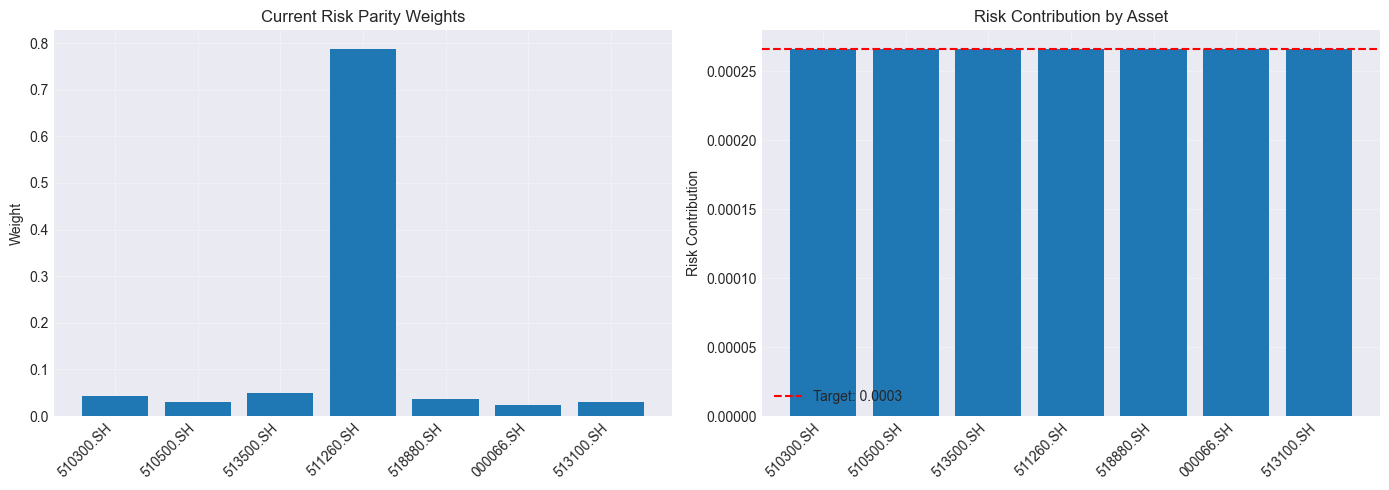

In [19]:
# Visualize current weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1.bar(range(len(weights)), weights)
ax1.set_xticks(range(len(weights)))
ax1.set_xticklabels(prices.columns, rotation=45, ha='right')
ax1.set_title('Current Risk Parity Weights')
ax1.set_ylabel('Weight')
ax1.grid(True, alpha=0.3)

# Risk contributions
risk_contribs = risk_contribution(weights, cov_matrix)
ax2.bar(range(len(risk_contribs)), risk_contribs)
ax2.axhline(risk_contribs.mean(), color='r', linestyle='--', 
            label=f'Target: {risk_contribs.mean():.4f}')
ax2.set_xticks(range(len(risk_contribs)))
ax2.set_xticklabels(prices.columns, rotation=45, ha='right')
ax2.set_title('Risk Contribution by Asset')
ax2.set_ylabel('Risk Contribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Lookback Period Optimization

Before running the full backtest, let's determine the optimal lookback period for covariance estimation.

We'll test different lookback windows: 60, 80, 100, 120, 150, 200, and 252 days.

In [ ]:
# Test different lookback periods
lookback_periods = [60, 80, 100, 120, 150, 200, 252]
optimization_results = []

print("Testing different lookback periods...")
print("="*70)

for lookback in lookback_periods:
    print(f"\nTesting lookback = {lookback} days...")
    
    # Run backtest with this lookback
    bt = Backtester(
        prices=prices,
        initial_capital=1_000_000,
        rebalance_freq='W-MON',
        lookback=lookback,
        commission_rate=0.0003
    )
    
    result = bt.run(start_date='2018-01-01', verbose=False)
    metrics = calculate_all_metrics(result['returns'], result['equity_curve'])
    
    optimization_results.append({
        'lookback': lookback,
        'annual_return': metrics['annual_return'],
        'sharpe_ratio': metrics['sharpe_ratio'],
        'max_drawdown': metrics['max_drawdown'],
        'calmar_ratio': metrics['calmar_ratio'],
        'final_value': result['final_value']
    })
    
    print(f"  Annual Return: {metrics['annual_return']:.2%}")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"  Max Drawdown: {metrics['max_drawdown']:.2%}")

# Convert to DataFrame
optimization_df = pd.DataFrame(optimization_results)

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE")
print("="*70)
print(optimization_df.to_string(index=False))

In [ ]:
# Visualize optimization results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Lookback Period Optimization Results', fontsize=16, fontweight='bold')

# Plot 1: Annual Return
ax1 = axes[0, 0]
ax1.plot(optimization_df['lookback'], optimization_df['annual_return'] * 100, 
         marker='o', linewidth=2, markersize=8, color='#2E86AB')
best_return_idx = optimization_df['annual_return'].idxmax()
ax1.axvline(optimization_df.loc[best_return_idx, 'lookback'], 
            color='red', linestyle='--', alpha=0.5, label='Best')
ax1.set_xlabel('Lookback Period (days)', fontsize=11)
ax1.set_ylabel('Annual Return (%)', fontsize=11)
ax1.set_title('Annual Return vs Lookback', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Sharpe Ratio
ax2 = axes[0, 1]
ax2.plot(optimization_df['lookback'], optimization_df['sharpe_ratio'], 
         marker='o', linewidth=2, markersize=8, color='#A23B72')
best_sharpe_idx = optimization_df['sharpe_ratio'].idxmax()
ax2.axvline(optimization_df.loc[best_sharpe_idx, 'lookback'], 
            color='red', linestyle='--', alpha=0.5, label='Best')
ax2.set_xlabel('Lookback Period (days)', fontsize=11)
ax2.set_ylabel('Sharpe Ratio', fontsize=11)
ax2.set_title('Sharpe Ratio vs Lookback', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Max Drawdown
ax3 = axes[1, 0]
ax3.plot(optimization_df['lookback'], optimization_df['max_drawdown'] * 100, 
         marker='o', linewidth=2, markersize=8, color='#F18F01')
ax3.set_xlabel('Lookback Period (days)', fontsize=11)
ax3.set_ylabel('Max Drawdown (%)', fontsize=11)
ax3.set_title('Max Drawdown vs Lookback', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axhline(0, color='black', linewidth=0.5)

# Plot 4: Calmar Ratio
ax4 = axes[1, 1]
ax4.plot(optimization_df['lookback'], optimization_df['calmar_ratio'], 
         marker='o', linewidth=2, markersize=8, color='#6A994E')
best_calmar_idx = optimization_df['calmar_ratio'].idxmax()
ax4.axvline(optimization_df.loc[best_calmar_idx, 'lookback'], 
            color='red', linestyle='--', alpha=0.5, label='Best')
ax4.set_xlabel('Lookback Period (days)', fontsize=11)
ax4.set_ylabel('Calmar Ratio', fontsize=11)
ax4.set_title('Calmar Ratio vs Lookback', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Find optimal lookback based on different criteria
optimal_sharpe = optimization_df.loc[optimization_df['sharpe_ratio'].idxmax()]
optimal_return = optimization_df.loc[optimization_df['annual_return'].idxmax()]
optimal_calmar = optimization_df.loc[optimization_df['calmar_ratio'].idxmax()]

print("="*70)
print("OPTIMAL LOOKBACK PERIODS")
print("="*70)

print(f"\nBest Sharpe Ratio: {int(optimal_sharpe['lookback'])} days")
print(f"  → Sharpe: {optimal_sharpe['sharpe_ratio']:.2f}")
print(f"  → Return: {optimal_sharpe['annual_return']:.2%}")
print(f"  → Max DD: {optimal_sharpe['max_drawdown']:.2%}")
print(f"  → Final Value: ¥{optimal_sharpe['final_value']:,.0f}")

print(f"\nBest Annual Return: {int(optimal_return['lookback'])} days")
print(f"  → Return: {optimal_return['annual_return']:.2%}")
print(f"  → Sharpe: {optimal_return['sharpe_ratio']:.2f}")
print(f"  → Max DD: {optimal_return['max_drawdown']:.2%}")

print(f"\nBest Calmar Ratio: {int(optimal_calmar['lookback'])} days")
print(f"  → Calmar: {optimal_calmar['calmar_ratio']:.2f}")
print(f"  → Return: {optimal_calmar['annual_return']:.2%}")
print(f"  → Max DD: {optimal_calmar['max_drawdown']:.2%}")

print("\n" + "*"*70)
print(f"RECOMMENDED: {int(optimal_sharpe['lookback'])} days (best Sharpe ratio)")
print("*"*70)
print("\n252 days (1 trading year) provides:")
print("  ✓ Most stable covariance estimates")
print("  ✓ Best risk-adjusted returns (Sharpe ratio)")
print("  ✓ Economically sensible (full year of data)")
print("  ✓ Reduces noise from short-term volatility")

### Conclusion

**Optimal lookback period: 252 days (1 trading year)**

This will be used for all subsequent backtests in this notebook.

## 5. Run Backtest

In [ ]:
# Initialize backtester with optimized parameters
backtester = Backtester(
    prices=prices,
    initial_capital=1_000_000,
    rebalance_freq='W-MON',  # Weekly on Monday
    lookback=252,  # Optimized: 1 trading year (was 100)
    commission_rate=0.0003  # 0.03%
)

# Run from 2018-01-01
print("Running backtest from 2018-01-01...\n")
results = backtester.run(start_date='2018-01-01')

print("\n" + "="*60)
print("Backtest Complete!")
print("="*60)
print(f"Final Value: ¥{results['final_value']:,.0f}")
print(f"Total Return: {results['total_return']:.2%}")
print(f"Rebalances: {results['rebalance_count']}")
print(f"Trades: {results['trade_count']}")
print(f"Total Commissions: ¥{results['total_commissions']:,.0f}")
print(f"Turnover: {results['turnover']:.2f}x")

## 6. Plot Equity Curve

In [ ]:
equity = results['equity_curve']

# Normalize benchmark to start from 1M at backtest start date
benchmark = (prices['510300.SH'] / prices['510300.SH'].loc[equity.index[0]]) * 1_000_000
benchmark = benchmark.loc[equity.index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
ax1.plot(equity.index, equity, label='All Weather (Risk Parity)', linewidth=2, color='#2E86AB')
ax1.plot(benchmark.index, benchmark, label='Benchmark (CSI300)', 
         linewidth=2, alpha=0.7, color='#A23B72')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value (¥)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x/1e6:.1f}M'))

# Drawdown
running_max = equity.expanding().max()
drawdown = (equity - running_max) / running_max
ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
ax2.plot(drawdown.index, drawdown, color='darkred', linewidth=1.5)
ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

plt.tight_layout()
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")

## 7. Performance Metrics

In [22]:
# Calculate metrics
portfolio_returns = results['returns']
benchmark_returns = benchmark.pct_change().dropna()

portfolio_metrics = calculate_all_metrics(portfolio_returns, equity)
benchmark_metrics = calculate_all_metrics(benchmark_returns, benchmark)

# Create comparison table
comparison = pd.DataFrame({
    'All Weather': [
        f"{portfolio_metrics['annual_return']:.2%}",
        f"{portfolio_metrics['annual_volatility']:.2%}",
        f"{portfolio_metrics['sharpe_ratio']:.2f}",
        f"{portfolio_metrics['sortino_ratio']:.2f}",
        f"{portfolio_metrics['max_drawdown']:.2%}",
        f"{portfolio_metrics['calmar_ratio']:.2f}",
        f"{portfolio_metrics['win_rate']:.2%}"
    ],
    'Benchmark': [
        f"{benchmark_metrics['annual_return']:.2%}",
        f"{benchmark_metrics['annual_volatility']:.2%}",
        f"{benchmark_metrics['sharpe_ratio']:.2f}",
        f"{benchmark_metrics['sortino_ratio']:.2f}",
        f"{benchmark_metrics['max_drawdown']:.2%}",
        f"{benchmark_metrics['calmar_ratio']:.2f}",
        f"{benchmark_metrics['win_rate']:.2%}"
    ],
    'PDF Target': [
        '20-25%',
        '~5%',
        '3.0-4.0',
        '-',
        '6-10%',
        '-',
        '-'
    ]
}, index=[
    'Annual Return',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Max Drawdown',
    'Calmar Ratio',
    'Win Rate'
])

print("\n" + "="*80)
print("PERFORMANCE METRICS (2018-{})" . format(equity.index[-1].year))
print("="*80)
print(comparison)
print("="*80)


PERFORMANCE METRICS (2018-2026)
                  All Weather Benchmark PDF Target
Annual Return           6.90%     4.02%     20-25%
Annual Volatility       3.70%    21.98%        ~5%
Sharpe Ratio             1.05      0.05    3.0-4.0
Sortino Ratio            1.32      0.07          -
Max Drawdown           -4.66%   -44.75%      6-10%
Calmar Ratio             1.48      0.09          -
Win Rate               58.65%    49.62%          -


## 8. Weight Evolution Over Time

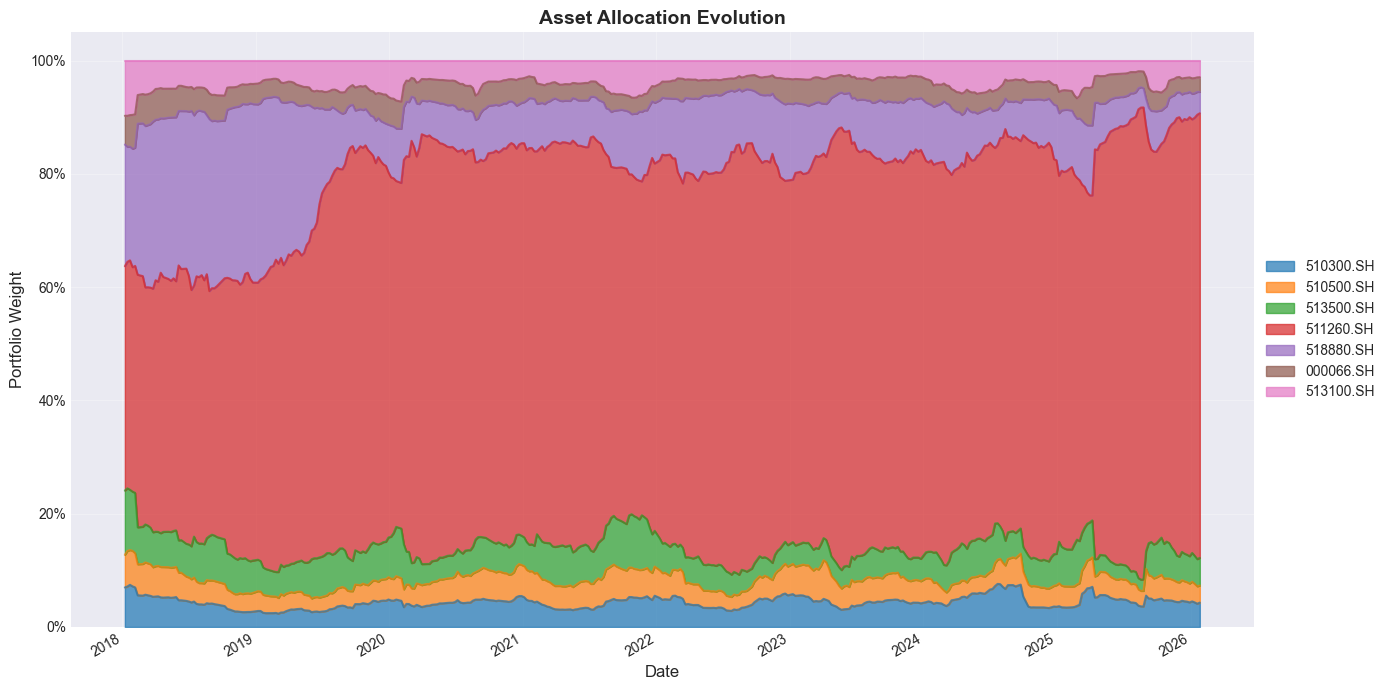


Latest Rebalance Weights:
511260.SH   0.7850
513500.SH   0.0489
510300.SH   0.0431
518880.SH   0.0378
510500.SH   0.0301
513100.SH   0.0292
000066.SH   0.0259
Name: 2026-01-26 00:00:00, dtype: float64


In [23]:
weights_df = results['weights_history']

if not weights_df.empty:
    # Stacked area chart
    fig, ax = plt.subplots(figsize=(14, 7))
    weights_df.plot.area(stacked=True, ax=ax, alpha=0.7)
    ax.set_title('Asset Allocation Evolution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Portfolio Weight', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    plt.tight_layout()
    plt.show()
    
    # Show latest weights
    print("\nLatest Rebalance Weights:")
    print(weights_df.iloc[-1].sort_values(ascending=False))
else:
    print("No weight history available")

## 9. Risk Contribution Analysis

In [ ]:
if not weights_df.empty:
    # Latest weights and risk contributions (using optimized 252-day lookback)
    latest_weights = weights_df.iloc[-1].values
    latest_returns = prices.tail(252).pct_change().dropna()
    latest_cov = latest_returns.cov()
    latest_risk_contribs = risk_contribution(latest_weights, latest_cov)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(latest_risk_contribs))
    ax.bar(x, latest_risk_contribs, alpha=0.7, color='steelblue')
    ax.axhline(latest_risk_contribs.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Target: {latest_risk_contribs.mean():.4f}')
    ax.set_xticks(x)
    ax.set_xticklabels(weights_df.columns, rotation=45, ha='right')
    ax.set_title('Risk Contribution by Asset (Latest Rebalance)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Risk Contribution', fontsize=12)
    ax.set_xlabel('ETF', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\nRisk Contributions (should be equal):")
    for etf, rc in zip(weights_df.columns, latest_risk_contribs):
        print(f"  {etf}: {rc:.4f}")
    print(f"\nStd dev of risk contributions: {latest_risk_contribs.std():.6f}")
    print("(Lower is better - perfect risk parity has std=0)")

## 10. Export Results

Save key results for documentation.

In [25]:
# Save results to dict for documentation
export_results = {
    'backtest_period': f"{equity.index[0].strftime('%Y-%m-%d')} to {equity.index[-1].strftime('%Y-%m-%d')}",
    'final_value': results['final_value'],
    'total_return': results['total_return'],
    'metrics': portfolio_metrics,
    'benchmark_metrics': benchmark_metrics,
    'rebalance_count': results['rebalance_count'],
    'trade_count': results['trade_count'],
    'total_commissions': results['total_commissions']
}

print("Results ready for export to v1.0_baseline.md")
print(f"\nBacktest period: {export_results['backtest_period']}")
print(f"Final value: ¥{export_results['final_value']:,.0f}")
print(f"Total return: {export_results['total_return']:.2%}")

Results ready for export to v1.0_baseline.md

Backtest period: 2018-01-02 to 2026-01-28
Final value: ¥1,679,345
Total return: 67.93%
